In [20]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd

import plotting

In [21]:
METHODS = plotting.METHODS + ['pearl_leqt_072025','pearl_xl_072025','pearl_xl_0530_gems_ft','pearl_leqt_0530']

In [22]:
data_dir = Path("data/paper_data")
figures_dir = data_dir / "figures"
figures_dir.mkdir(exist_ok=True)

In [23]:
annotated_df = pd.read_csv(data_dir / "annotations.csv")
annotated_df["release_date"] = pd.to_datetime(annotated_df["target_release_date"])

In [24]:
proto_df = pd.read_csv(data_dir / "predictions" / "af3.csv")
keep_columns = proto_df.columns

In [25]:
for ours in ['pearl_leqt_072025','pearl_xl_072025','pearl_xl_0530_gems_ft','pearl_leqt_0530']:
    dftemp = pd.read_csv(data_dir / "pearl" / f"{ours}.csv")
    dftemp['method'] = ours
    dftemp = dftemp.merge(annotated_df, on=['system_id', 'ligand_instance_chain'])
    dftemp['target'] = dftemp['system_id']
    dftemp = dftemp.filter(items=keep_columns)
    dftemp.to_csv(data_dir / "predictions" / f"{ours}.csv", index=False)
len(dftemp)

6320

In [26]:
dftemp.head()

,target,method,sample,lddt_pli,ligand_ccd_code,rmsd,ligand_instance_chain,ligand_is_proper
0,8tnc__1__1.B__1.E,pearl_leqt_0530,0,0.902378,3JD,0.778434,1.E,True
1,8tnc__1__1.B__1.E,pearl_leqt_0530,1,0.906738,3JD,0.871322,1.E,True
2,8tnc__1__1.B__1.E,pearl_leqt_0530,2,0.875173,3JD,0.965022,1.E,True
3,8tnc__1__1.B__1.E,pearl_leqt_0530,3,0.906427,3JD,0.755973,1.E,True
4,8tnc__1__1.B__1.E,pearl_leqt_0530,4,0.883646,3JD,0.973289,1.E,True


In [27]:
all_similarity_scores = pd.read_parquet(data_dir / "all_similarity_scores.parquet")

In [28]:
bust_dfs = {}
for m in METHODS:
    filename = data_dir / "posebusters_results" / f"{m}.csv"
    if filename.exists():
        bust_dfs[m] = pd.read_csv(filename)

In [29]:
full_datasets = {}
for method in METHODS:
    filename = data_dir / "predictions" / f"{method}.csv"
    df = pd.read_csv(filename, low_memory=False)
    keep_columns = [
        "target",
        "ligand_instance_chain",
        "lddt_pli",
        "rmsd",
        "lddt_lp",
        "bb_rmsd",
        "seed",
        "sample",
        "ranking_score",
        "ligand_is_proper",
        "prot_lig_chain_iptm_average_lddt_pli",
        "prot_lig_chain_iptm_min_lddt_pli",
        "prot_lig_chain_iptm_max_lddt_pli",
        "lig_prot_chain_iptm_average_lddt_pli",
        "lig_prot_chain_iptm_min_lddt_pli",
        "lig_prot_chain_iptm_max_lddt_pli",
        "prot_lig_chain_iptm_average_rmsd",
        "prot_lig_chain_iptm_min_rmsd",
        "prot_lig_chain_iptm_max_rmsd",
        "lig_prot_chain_iptm_average_rmsd",
        "lig_prot_chain_iptm_min_rmsd",
        "lig_prot_chain_iptm_max_rmsd",
        "model_ligand_chain_lddt_pli",
        "model_ligand_chain_rmsd",
        "ligand_ccd_code",
        "model_ligand_smiles",
        "pred_pocket_f1",
    ]
    if "seed" not in df.columns:
        df["seed"] = 1
    if "sample" not in df.columns:
        df["sample"] = 1
    if "ranking_score" not in df.columns:
        df["ranking_score"] = 1
    if "lig_prot_chain_iptm_average_rmsd" not in df.columns:
        df["lig_prot_chain_iptm_average_rmsd"] = 1
    if "prot_lig_chain_iptm_average_rmsd" not in df.columns:
        df["prot_lig_chain_iptm_average_rmsd"] = 1
    if "pred_pocket_f1" not in df.columns:
        df["pred_pocket_f1"] = 1
    keep_columns = [c for c in keep_columns if c in df.columns]
    full_datasets[method] = (
        df[keep_columns].rename(columns={"target": "system_id"}).reset_index(drop=True)
    )
    full_datasets[method]["group_key"] = (
        full_datasets[method]["system_id"]
        + "__"
        + full_datasets[method]["ligand_instance_chain"]
    )
    full_datasets[method]["method"] = method
    full_datasets[method] = (
        full_datasets[method]
        .sort_values(by=["lddt_pli", "rmsd"], ascending=[False, True])
        .groupby(["group_key", "seed", "sample"])
        .head(1)
        .reset_index(drop=True)
    )
    if method in bust_dfs:
        full_datasets[method] = full_datasets[method].merge(
            bust_dfs[method][["system_id", "ligand_instance_chain", "pb_success", "sample", "seed"]],
            on=["system_id", "ligand_instance_chain", "sample", "seed"],
            how="left",
        )
        full_datasets[method]["pb_success"] = (
            full_datasets[method]["pb_success"].fillna(False).astype(float)
        )
    else:
        full_datasets[method]["pb_success"] = -1

In [30]:
INTERESTING_METHODS = ['af3','pearl_leqt_072025','pearl_xl_072025','pearl_xl_0530_gems_ft','pearl_leqt_0530']

In [31]:
def pivot_df(df, annotated_df):
    df = df.pivot(
        index=[
            "group_key",
            "system_id",
            "ligand_is_proper",
            "ligand_instance_chain",
        ],
        columns="method",
        values=[
            "lddt_pli",
            "rmsd",
            "lddt_lp",
            "bb_rmsd",
            "pb_success",
            "pred_pocket_f1",
        ],
    ).reset_index()
    df.columns = [f"{col[0]}_{col[1]}" if len(col[1]) else col[0] for col in df.columns]
    df = df[df["ligand_is_proper"].fillna(False)].reset_index(drop=True)
    merge_columns = [col for col in annotated_df.columns if col not in df.columns]
    df = df.merge(
        annotated_df[["group_key"] + merge_columns], on="group_key", how="left"
    )
    return df


top_dfs = {}
top_5_dfs = {}
best_5_dfs = {}
best_dfs = {}
worst_dfs = {}
random_dfs = {}
random_5_dfs = {}
rank_by = "rmsd"
rank_ascending = True
for m in full_datasets:
    top_dfs[m] = (
        full_datasets[m]
        .sort_values(by=rank_by, ascending=rank_ascending)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    best_dfs[m] = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=False)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    worst_dfs[m] = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=True)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    random_dfs[m] = (
        full_datasets[m]
        .sample(frac=1)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    all_top = (
        full_datasets[m]
        .sort_values(by=rank_by, ascending=rank_ascending)
        .groupby(["group_key", "seed"])
        .head(1)
    )

    all_top["Rank"] = all_top.groupby("group_key")[rank_by].rank(
        ascending=False, method="first"
    )
    top_5_dfs[m] = []

    for rank in range(1, 6):
        df = all_top[all_top["Rank"] == rank]
        top_5_dfs[m].append(df)

    all_best = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=False)
        .groupby(["group_key", "seed"])
        .head(1)
    )
    all_best["Rank"] = all_best.groupby("group_key")["lddt_pli"].rank(
        ascending=False, method="first"
    )
    best_5_dfs[m] = []
    for rank in range(1, 6):
        df = all_best[all_best["Rank"] == rank]
        best_5_dfs[m].append(df)

    all_random = full_datasets[m].sample(frac=1).groupby(["group_key", "seed"]).head(1)
    all_random["Rank"] = all_random.groupby("group_key")[rank_by].rank(
        ascending=False, method="first"
    )
    random_5_dfs[m] = []
    for rank in range(1, 6):
        df = all_random[all_random["Rank"] == rank]
        random_5_dfs[m].append(df)

results_df_top = pivot_df(pd.concat(top_dfs.values()), annotated_df)
results_df_best = pivot_df(pd.concat(best_dfs.values()), annotated_df)
results_df_worst = pivot_df(pd.concat(worst_dfs.values()), annotated_df)
results_df_random = pivot_df(pd.concat(random_dfs.values()), annotated_df)
results_df_top_5 = []
results_df_best_5 = []
results_df_random_5 = []
for i in range(5):
    results_df_top_5.append(
        pivot_df(pd.concat([top_5_dfs[m][i] for m in top_5_dfs]), annotated_df)
    )
    results_df_best_5.append(
        pivot_df(pd.concat([best_5_dfs[m][i] for m in best_5_dfs]), annotated_df)
    )
    results_df_random_5.append(
        pivot_df(pd.concat([random_5_dfs[m][i] for m in random_5_dfs]), annotated_df)
    )

dfs = {
    "top": results_df_top,
    "best": results_df_best,
    "worst": results_df_worst,
    "random": results_df_random,
}
for i in range(5):
    dfs[f"top_5_{i + 1}"] = results_df_top_5[i]
    dfs[f"best_5_{i + 1}"] = results_df_best_5[i]
    dfs[f"random_5_{i + 1}"] = results_df_random_5[i]

for df_name in dfs:
    dfs[df_name]["lddt_pli_max"] = np.nanmax(
        dfs[df_name][
            [
                f"lddt_pli_{m}"
                for m in METHODS
                if f"lddt_pli_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )
    dfs[df_name]["rmsd_min"] = np.nanmin(
        dfs[df_name][
            [
                f"rmsd_{m}"
                for m in METHODS
                if f"rmsd_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )
    dfs[df_name]["lddt_pli_average"] = np.nanmedian(
        dfs[df_name][
            [
                f"lddt_pli_{m}"
                for m in METHODS
                if f"lddt_pli_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )
    dfs[df_name]["rmsd_average"] = np.nanmedian(
        dfs[df_name][
            [
                f"rmsd_{m}"
                for m in METHODS
                if f"rmsd_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )

common_subset_dfs_all = {}
cluster_dfs_all = {}
for df in dfs:
    if len([c for c in dfs[df].columns if 'pearl' in c]) == 0:
        # cheat
        continue

    common_subset_dfs_all[df] = (
        dfs[df]
        .dropna(
            subset=[f"lddt_pli_{method}" for method in INTERESTING_METHODS]
            + ["sucos_shape"]
        )
        .reset_index(drop=True)
    )
    cluster_dfs_all[df] = (
        common_subset_dfs_all[df][
            common_subset_dfs_all[df]["ligand_is_proper"]
            & (common_subset_dfs_all[df]["sucos_shape"].notna())
        ]
        .sort_values(by=plotting.SIMILARITY_METRIC)
        .groupby("cluster")
        .head(1)
    )

In [32]:
print("Common subset:")
print("No. systems", common_subset_dfs_all["top"].system_id.nunique())
print("No. proper ligands", common_subset_dfs_all["top"]["ligand_is_proper"].sum())
print(
    "No. ligands",
    annotated_df[
        annotated_df["system_id"].isin(common_subset_dfs_all["top"]["system_id"])
    ].shape[0],
)

Common subset:
No. systems 232
No. proper ligands 262
No. ligands 384


In [33]:
NAME_MAPPING = plotting.NAME_MAPPING
NAME_MAPPING['pearl_leqt_072025'] = 'Pearl-LEQT 072025'
NAME_MAPPING['pearl_xl_072025'] = 'Pearl-XL 072025'
NAME_MAPPING['pearl_xl_0530_gems_ft'] = 'Pearl-XL 0530 Gems FT'
NAME_MAPPING['pearl_leqt_0530'] = 'Pearl-LEQT 0530'

SHAPES = plotting.SHAPES
SHAPES['pearl_leqt_072025'] = 'D'
SHAPES['pearl_xl_072025'] = '8'
SHAPES['pearl_xl_0530_gems_ft'] = 's'
SHAPES['pearl_leqt_0530'] = 'd'
COLORS = plotting.COLORS
COLORS['pearl_leqt_072025'] = '#000000'
COLORS['pearl_xl_072025'] = '#006600'
COLORS['pearl_xl_0530_gems_ft'] = '#CC00CC'
COLORS['pearl_leqt_0530'] = '#CC0000'


In [34]:
def make_one_plot(
    df,
    ax,
    title,
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=plotting.COMMON_SUBSET_METHODS,
    legend_loc="lower right",
    ylabel="Success Rate (%)",
    xlabel="Similarity to the training set",
):
    df = df[df["sucos_shape"].notna() & df["ligand_is_proper"]].reset_index(drop=True)
    for method in methods:
        plotting.plot_success_by_similarity(
            df,
            ax=ax,
            lddt_pli_column=f"lddt_pli_{method}",
            rmsd_column=f"rmsd_{method}",
            label=NAME_MAPPING[method],
            shape=SHAPES[method],
            color=COLORS[method],
            rmsd_threshold=rmsd_threshold,
            lddt_pli_threshold=lddt_pli_threshold,
            similarity_metric=similarity_metric,
            similarity_bins=similarity_bins,
        )

    plotting.plot_success_by_similarity(
        df,
        ax=ax,
        lddt_pli_column="lddt_pli_max",
        rmsd_column="rmsd_min",
        label="Best",
        shape="*",
        color=plotting.COLORS["best"],
        rmsd_threshold=rmsd_threshold,
        lddt_pli_threshold=lddt_pli_threshold,
        similarity_metric=similarity_metric,
        similarity_bins=similarity_bins,
    )
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
    ax.text(0.015, 0.99, title, transform=ax.transAxes, fontsize=14, fontweight="bold")
    if legend_loc is not None:
        ax.legend(loc=legend_loc, frameon=False)

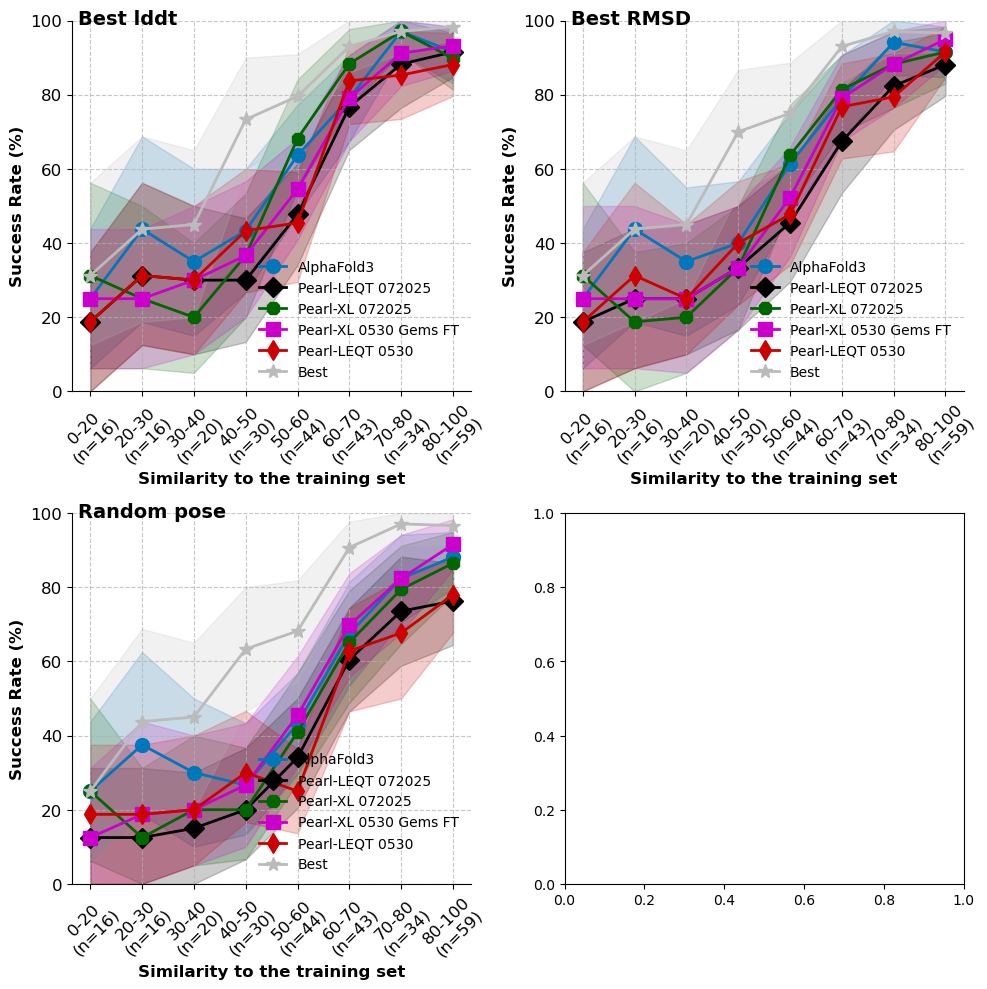

In [35]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(figsize=(10,10),ncols=2,nrows=2)

make_one_plot(
    common_subset_dfs_all["best"],
    axs[0,0],
    title="Best lddt",
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=INTERESTING_METHODS,
    legend_loc="lower right",
)

make_one_plot(
    common_subset_dfs_all["top"],
    axs[0,1],
    title="Best RMSD",
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=INTERESTING_METHODS,
    legend_loc="lower right",
)


make_one_plot(
    common_subset_dfs_all["random"],
    axs[1,0],
    title="Random pose",
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=INTERESTING_METHODS,
    legend_loc="lower right",
)

fig.tight_layout()

In [39]:
from matplotlib.patches import Rectangle

def make_one_plot_pb(
    df,
    ax,
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=plotting.COMMON_SUBSET_METHODS,
    bar_width=0.18,
    fontsize=8,
    title="huh"
):
    df = df[df["sucos_shape"].notna() & df["ligand_is_proper"]].reset_index(drop=True)

    total_width = len(methods) * bar_width
    start_offset = -total_width / 2 + bar_width / 2

    bin_sizes = None
    for i, method in enumerate(methods):
        x_offset = start_offset + i * bar_width
        ax, sizes = plotting.plot_success_by_similarity_pb(
            df,
            ax=ax,
            lddt_pli_column=f"lddt_pli_{method}",
            rmsd_column=f"rmsd_{method}",
            pb_success_column=f"pb_success_{method}",
            label=NAME_MAPPING[method],
            color=COLORS[method],
            rmsd_threshold=rmsd_threshold,
            lddt_pli_threshold=lddt_pli_threshold,
            similarity_metric=similarity_metric,
            similarity_bins=similarity_bins,
            x_offset=x_offset,
            bar_width=bar_width,
            fontsize=fontsize,
        )
        if bin_sizes is None:
            bin_sizes = sizes

    solid_patch = Rectangle((0, 0), 1, 1, facecolor="gray", edgecolor="black")
    hatched_patch = Rectangle(
        (0, 0), 1, 1, facecolor="white", hatch="///", edgecolor="black"
    )
    all_handles = [
        solid_patch,
        hatched_patch,
    ]
    sub_title = f"RMSD ≤ {rmsd_threshold}Å"
    if lddt_pli_threshold > 0:
        sub_title += f" & LDDT-PLI ≥ {lddt_pli_threshold}"
    all_labels = [
        f"{sub_title} & PB-Valid",
        f"{sub_title} only",
    ]

    ax.legend(all_handles, all_labels, loc="upper left", frameon=False)
    ax.grid(True, linestyle="--", alpha=0.7, zorder=0)
    ax.set_xlim(
        -total_width / 2 - bar_width / 2,
        len(similarity_bins) - 2 + total_width / 2 + bar_width / 2,
    )
    ax.text(0.015, 0.99, title, transform=ax.transAxes, fontsize=14, fontweight="bold")


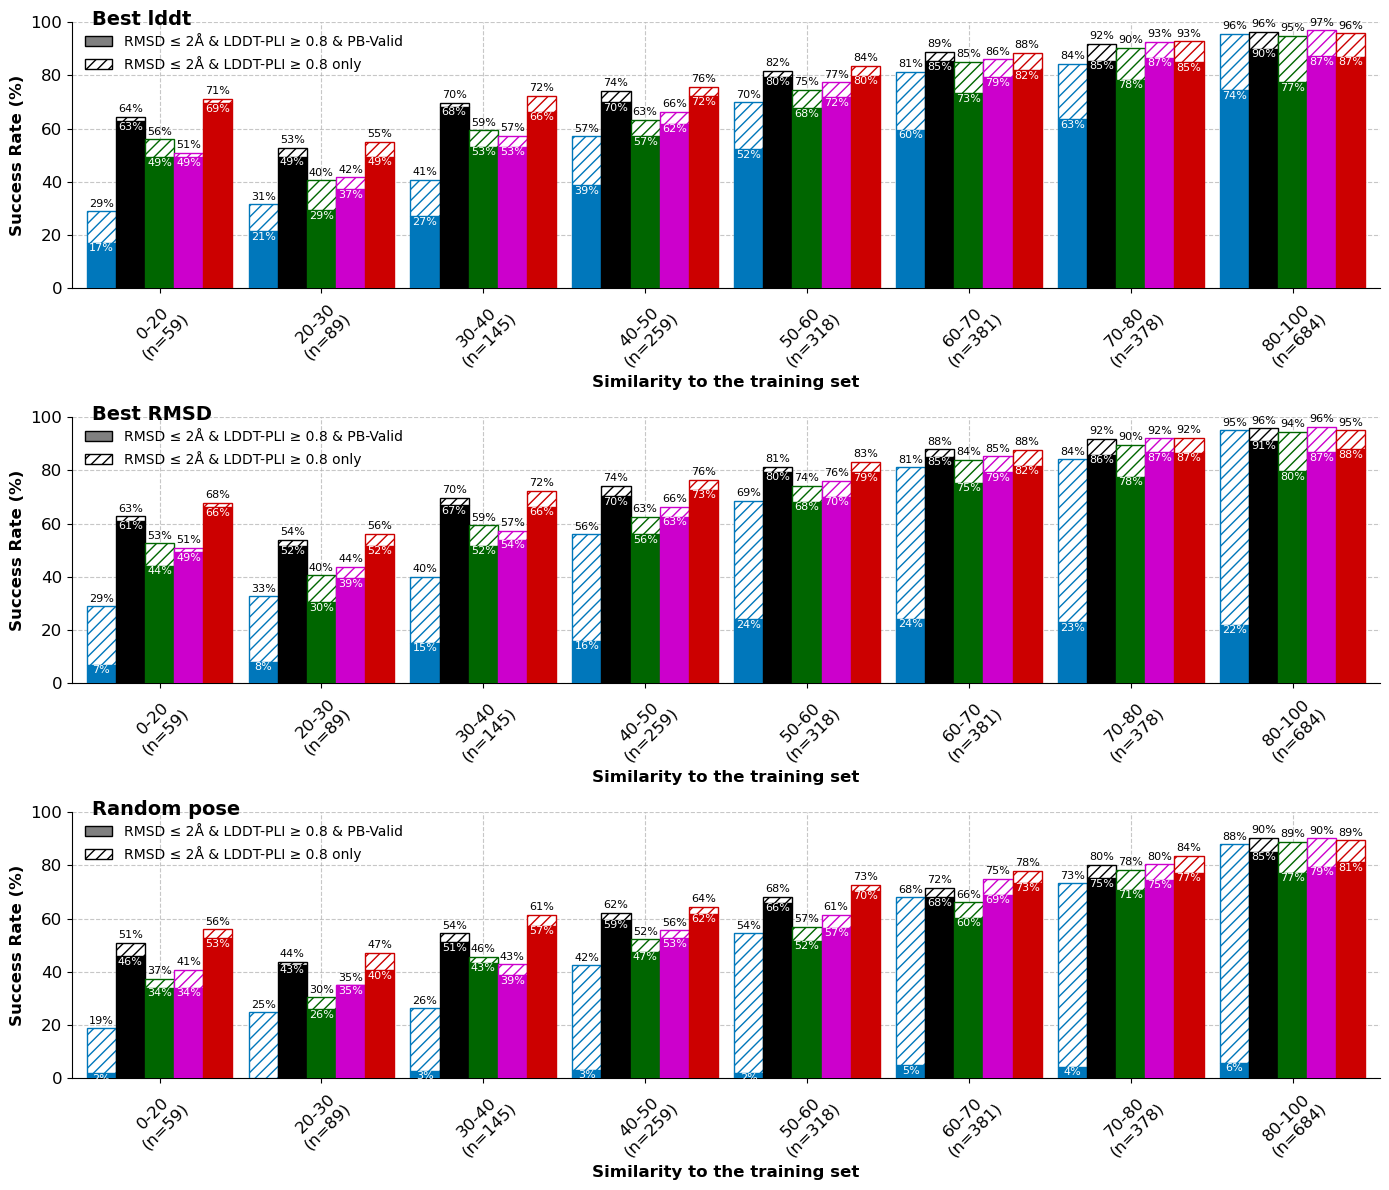

In [40]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(figsize=(14,12),nrows=3)

make_one_plot_pb(
    common_subset_dfs_all["best"],
    axs[0],
    title="Best lddt",
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=INTERESTING_METHODS,
)

make_one_plot_pb(
    common_subset_dfs_all["top"],
    axs[1],
    title="Best RMSD",
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=INTERESTING_METHODS,
)


make_one_plot_pb(
    common_subset_dfs_all["random"],
    axs[2],
    title="Random pose",
    similarity_metric=plotting.SIMILARITY_METRIC,
    similarity_bins=plotting.SIMILARITY_BINS,
    lddt_pli_threshold=plotting.LDDT_PLI_THRESHOLD,
    rmsd_threshold=plotting.RMSD_THRESHOLD,
    methods=INTERESTING_METHODS,
)

fig.tight_layout()

In [93]:
common_subset_dfs_all['top'].filter(
    items=['system_id','rmsd_af3','rmsd_pearl_leqt_072025','lddt_pli_af3','lddt_pli_pearl_leqt_072025','sucos_shape','sucos_shape_pocket_qcov']
).sort_values(by='sucos_shape_pocket_qcov').head(10)

,system_id,rmsd_af3,rmsd_pearl_leqt_072025,lddt_pli_af3,lddt_pli_pearl_leqt_072025,sucos_shape,sucos_shape_pocket_qcov
12,5sdh__1__1.A_1.B__1.F,27.279203,26.587921,0.000000,0.000000,31.494218,0.0
797,7ocr__1__1.B__1.W_1.X,0.439387,1.105883,0.903051,0.768041,50.427146,0.0
796,7ocr__1__1.B__1.W_1.X,0.444570,0.449126,0.921835,0.913830,10.014972,0.0
1800,8cjg__1__1.A__1.D,0.952709,0.122450,0.822653,0.983333,42.139927,0.0
2192,8jjq__1__1.A__1.D,0.578574,0.378928,0.918717,0.904361,28.780088,0.0
1852,8d0f__1__1.A_1.B__1.D,2.793842,2.219921,0.696950,0.684723,33.108239,0.0
1851,8d0e__1__1.B__1.D,2.717031,4.905293,0.724138,0.734463,37.192507,0.0
795,7ocp__1__1.B__1.J_1.K,0.463049,0.485227,0.883994,0.938691,15.900938,0.0
348,7ftm__1__1.A__1.C,30.645046,30.454473,0.000000,0.000000,46.779773,0.0
1520,7yzm__1__1.C_1.D__1.AA_1.FA_1.Z,21.208277,42.114933,0.000000,0.000000,57.629560,0.0


Text(0, 0.5, 'RMSD (Å) of Pearl-LEQT 072025')

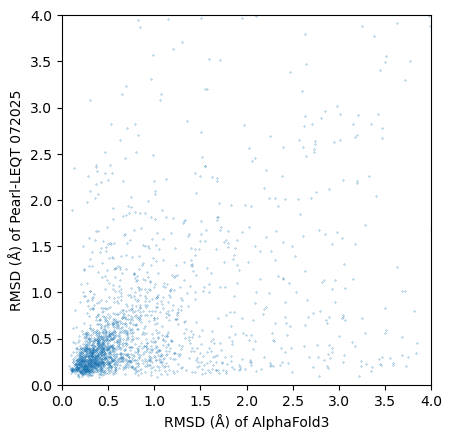

In [110]:
fig,ax = plt.subplots()

ax.scatter(common_subset_dfs_all['best']['rmsd_af3'],common_subset_dfs_all['best']['rmsd_pearl_leqt_072025'],marker='.', s=0.2)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect('equal')
ax.set_xlabel('RMSD (Å) of AlphaFold3')
ax.set_ylabel('RMSD (Å) of Pearl-LEQT 072025')


Text(0.5, 1.0, 'Similarity < 20%')

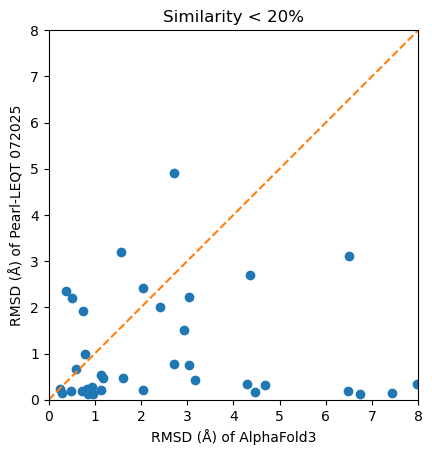

In [57]:
fig,ax = plt.subplots()

df1 = common_subset_dfs_all['best']
df1 = df1[df1['sucos_shape_pocket_qcov'] < 20]

ax.scatter(df1['rmsd_af3'],df1['rmsd_pearl_leqt_072025'],marker='o')
ax.plot([0,8],[0,8],color='C1',linestyle='--')
ax.set_xlim(0,8)
ax.set_ylim(0,8)
ax.set_aspect('equal')
ax.set_xlabel('RMSD (Å) of AlphaFold3')
ax.set_ylabel('RMSD (Å) of Pearl-LEQT 072025')
ax.set_title('Similarity < 20%')

In [62]:
df1[(df1['rmsd_af3'] > 2) & (df1['rmsd_pearl_leqt_072025'] < 1)].filter(items=['system_id','ligand_instance_chain','sucos_shape_pocket_qcov','rmsd_af3','rmsd_pearl_leqt_072025'])

,system_id,ligand_instance_chain,sucos_shape_pocket_qcov,rmsd_af3,rmsd_pearl_leqt_072025
313,7fee__1__1.A__1.E,1.E,19.385544,15.082805,0.278316
657,7ly6__1__1.A_2.A__1.B_1.C_1.D,1.B,2.472853,2.714729,0.774696
711,7nah__1__1.A__1.C,1.C,8.251175,3.173170,0.424656
712,7nai__1__1.A__1.C,1.C,8.210731,3.043924,0.752022
1216,7vpe__1__1.A__1.B,1.B,13.230484,23.713427,0.156161
1360,7xqz__1__1.A__1.B_1.C_1.D,1.B,19.638844,2.051895,0.212329
1409,7yv4__1__1.A__1.B,1.B,3.188092,4.466023,0.162255
1469,7zkw__1__1.A_1.C__1.E,1.E,3.947566,4.297521,0.338204
1490,7zzw__1__1.A__1.E_1.M,1.M,7.519023,15.137123,0.646292
1637,8c3u__1__1.A__1.C,1.C,6.568433,7.975697,0.338247


In [95]:
common_subset_dfs_all.keys()

dict_keys(['top', 'best', 'worst', 'random', 'top_5_1', 'best_5_1', 'random_5_1'])

In [96]:
for k,df in dfs.items():
    print(k,[c for c in df.columns if 'pearl' in c])

top ['lddt_pli_pearl_leqt_072025', 'rmsd_pearl_leqt_072025', 'lddt_lp_pearl_leqt_072025', 'bb_rmsd_pearl_leqt_072025', 'pb_success_pearl_leqt_072025', 'pred_pocket_f1_pearl_leqt_072025']
best ['lddt_pli_pearl_leqt_072025', 'rmsd_pearl_leqt_072025', 'lddt_lp_pearl_leqt_072025', 'bb_rmsd_pearl_leqt_072025', 'pb_success_pearl_leqt_072025', 'pred_pocket_f1_pearl_leqt_072025']
worst ['lddt_pli_pearl_leqt_072025', 'rmsd_pearl_leqt_072025', 'lddt_lp_pearl_leqt_072025', 'bb_rmsd_pearl_leqt_072025', 'pb_success_pearl_leqt_072025', 'pred_pocket_f1_pearl_leqt_072025']
random ['lddt_pli_pearl_leqt_072025', 'rmsd_pearl_leqt_072025', 'lddt_lp_pearl_leqt_072025', 'bb_rmsd_pearl_leqt_072025', 'pb_success_pearl_leqt_072025', 'pred_pocket_f1_pearl_leqt_072025']
top_5_1 ['lddt_pli_pearl_leqt_072025', 'rmsd_pearl_leqt_072025', 'lddt_lp_pearl_leqt_072025', 'bb_rmsd_pearl_leqt_072025', 'pb_success_pearl_leqt_072025', 'pred_pocket_f1_pearl_leqt_072025']
best_5_1 ['lddt_pli_pearl_leqt_072025', 'rmsd_pearl_leq

In [97]:
list(common_subset_dfs_all['top'].columns)

['group_key',
 'system_id',
 'ligand_is_proper',
 'ligand_instance_chain',
 'lddt_pli_af3',
 'lddt_pli_af3_no_template',
 'lddt_pli_boltz',
 'lddt_pli_boltz1x',
 'lddt_pli_boltz2',
 'lddt_pli_chai',
 'lddt_pli_pearl_leqt_072025',
 'lddt_pli_protenix',
 'lddt_pli_rfaa',
 'rmsd_af3',
 'rmsd_af3_no_template',
 'rmsd_boltz',
 'rmsd_boltz1x',
 'rmsd_boltz2',
 'rmsd_chai',
 'rmsd_pearl_leqt_072025',
 'rmsd_protenix',
 'rmsd_rfaa',
 'lddt_lp_af3',
 'lddt_lp_af3_no_template',
 'lddt_lp_boltz',
 'lddt_lp_boltz1x',
 'lddt_lp_boltz2',
 'lddt_lp_chai',
 'lddt_lp_pearl_leqt_072025',
 'lddt_lp_protenix',
 'lddt_lp_rfaa',
 'bb_rmsd_af3',
 'bb_rmsd_af3_no_template',
 'bb_rmsd_boltz',
 'bb_rmsd_boltz1x',
 'bb_rmsd_boltz2',
 'bb_rmsd_chai',
 'bb_rmsd_pearl_leqt_072025',
 'bb_rmsd_protenix',
 'bb_rmsd_rfaa',
 'pb_success_af3',
 'pb_success_af3_no_template',
 'pb_success_boltz',
 'pb_success_boltz1x',
 'pb_success_boltz2',
 'pb_success_chai',
 'pb_success_pearl_leqt_072025',
 'pb_success_protenix',
 'pb_s

In [101]:
bust_dfs['af3'].filter(items=['system_id','ligand_instance_chain','pb_success','sample','seed']).head()

,system_id,ligand_instance_chain,pb_success,sample,seed
0,7ojo__1__1.A_1.B__1.E_1.F,1.E,True,1,1894789330
1,7om1__1__1.A_1.B__1.E,1.E,True,2,3566649598
2,7olj__1__1.A_1.B__1.E,1.E,True,0,1331988934
3,7ojo__1__1.A_1.B__1.E_1.F,1.F,True,1,1894789330
4,7zzt__1__1.A__1.D_1.J,1.J,False,1,3163685747


In [ ]:
full_datasets['af3'].filter(items=['system_id','ligand_instance_chain','pb_success','sample','seed']).head()

,system_id,ligand_instance_chain,pb_success,sample,seed
0,7ok8__1__1.A__1.B_1.C_1.D,1.B,0.0,2,1601045677
1,7ok8__1__1.A__1.B_1.C_1.D,1.B,0.0,3,3031600397
2,7ok8__1__1.A__1.B_1.C_1.D,1.B,0.0,1,3137176835
3,7orq__1__1.A__1.B_1.C_1.D,1.B,0.0,3,1653837790
4,7ok8__1__1.A__1.B_1.C_1.D,1.B,0.0,1,3031600397


In [44]:
full_datasets['pearl_leqt_0530'].filter(items=['system_id','ligand_instance_chain','pb_success','sample','seed']).head()

,system_id,ligand_instance_chain,pb_success,sample,seed
0,8px2__1__1.A__1.B,1.B,1.0,19,1
1,7v45__1__1.A__1.B_1.C,1.B,1.0,14,1
2,8fic__1__1.A__1.B_1.C,1.C,1.0,14,1
3,8fic__1__1.A__1.B_1.C,1.C,1.0,9,1
4,8fic__1__1.A__1.B_1.C,1.C,1.0,6,1


In [43]:
pbaf3 = pd.read_csv(data_dir / "posebusters_results" / "af3.csv")

pbaf3['pb_success'].value_counts()

pb_success
True     3603
False    1255
Name: count, dtype: int64

In [45]:
full_datasets['af3']['pb_success'].value_counts()

pb_success
0.0    92739
1.0     3603
Name: count, dtype: int64